In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

In [2]:
def df_to_X_y2(df, window_size=6):
    df_as_np = df.to_numpy()
    X = []
    y = []
    
    for i in range(len(df_as_np)-window_size):
        row = [r for r in df_as_np[i:i+window_size]]
        X.append(row)
        label = df_as_np[i+window_size][6]
        y.append(label)
    
    return np.array(X), np.array(y)

In [3]:
df=pd.read_csv("train_data.csv")
df_to_X_y2(df)
X2_train, y2_train =df_to_X_y2(df)
df1=pd.read_csv("val_data.csv")
X2_val, y2_val = df_to_X_y2(df1)
df2=pd.read_csv("test_data.csv")
X2_test, y2_test = df_to_X_y2(df2)
X2_train.shape, y2_train.shape, X2_val.shape, y2_val.shape, X2_test.shape, y2_test.shape

((2836506, 6, 25),
 (2836506,),
 (945498, 6, 25),
 (945498,),
 (945498, 6, 25),
 (945498,))

In [4]:
def build_model(hp):
    model = keras.Sequential()
    model.add(LSTM(64))
    hp_act=hp.Choice('activation',values=['relu','linear','tanh'])
    model.add(keras.layers.Dense(
      hp.Choice('units', [8, 16, 32]),
      activation=hp_act))
  #model.add()
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.add(keras.layers.Dense(1, activation='relu'))
    model.compile(loss='mse',optimizer=Adam(learning_rate=hp_learning_rate))
    return model

In [5]:
# cp4 = ModelCheckpoint('model4/', save_best_only=True)
# model4.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

# model4.fit(X2_train, y2_train, validation_data=(X2_val, y2_val), epochs=3, callbacks=[cp4])

In [6]:
import keras_tuner
from tensorflow import keras
tuner = keras_tuner.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10)

tuner.search(X2_train, y2_train, epochs=25, validation_data=(X2_val, y2_val))
best_model = tuner.get_best_models()[0]

Trial 10 Complete [03h 42m 57s]
val_loss: 10399.00390625

Best val_loss So Far: 10318.421875
Total elapsed time: 1d 13h 41m 59s
INFO:tensorflow:Oracle triggered exit


In [7]:
# from sklearn.metrics import mean_squared_error as mse

# def plot_predictions1(model, X, y, start=0, end=100):
#     predictions = model.predict(X).flatten()
#     df = pd.DataFrame(data={'Predictions':predictions, 'Actuals':y})
#     plt.plot(df['Predictions'][start:end])
#     plt.plot(df['Actuals'][start:end])
#     return df, mse(y, predictions)

# plot_predictions1(model4, X2_test, y2_test)

In [8]:
print(tuner.results_summary(num_trials=1))

Results summary
Results in .\untitled_project
Showing 1 best trials
Objective(name="val_loss", direction="min")

Trial 07 summary
Hyperparameters:
activation: relu
units: 32
learning_rate: 0.0001
Score: 10318.421875
None


29547/29547 [==============================] - 73s 2ms/step


(        Predictions  Actuals
 0         59.223850    55.13
 1         56.141674    55.13
 2         57.899746    55.13
 3         58.229206    55.13
 4         59.068623    55.13
 ...             ...      ...
 945493   786.658081   601.44
 945494   577.865845   673.79
 945495   715.277649   999.36
 945496   898.885498  1100.89
 945497   998.170593  1181.49
 
 [945498 rows x 2 columns],
 11074.244103997686)

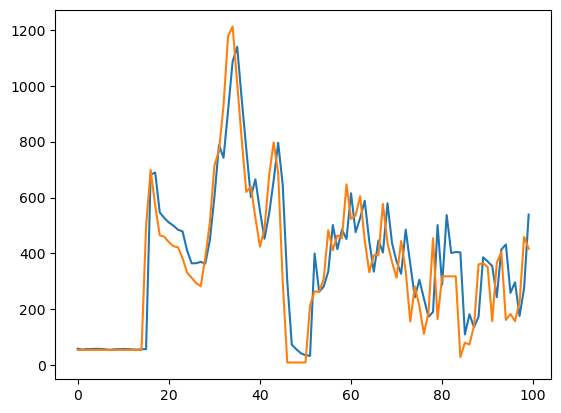

In [9]:
from sklearn.metrics import mean_squared_error as mse

def plot_predictions1(model, X, y, start=0, end=100):
    predictions = model.predict(X).flatten()
    df = pd.DataFrame(data={'Predictions':predictions, 'Actuals':y})
    plt.plot(df['Predictions'][start:end])
    plt.plot(df['Actuals'][start:end])
    return df, mse(y, predictions)

plot_predictions1(best_model, X2_test, y2_test)

In [10]:
y_p = best_model.predict(X2_test)

# convert array into dataframe
DF = pd.DataFrame(y_p)

# save the dataframe as a csv file
DF.to_csv("LSTM_Output.csv")

29547/29547 [==============================] - 96s 3ms/step


In [11]:
# from sklearn.metrics import accuracy_score
# print(accuracy_score(y_test,y_pred))
# print(accuracy_score(ytest, model.predict(xtest)))